In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<Axes: xlabel='DATE'>

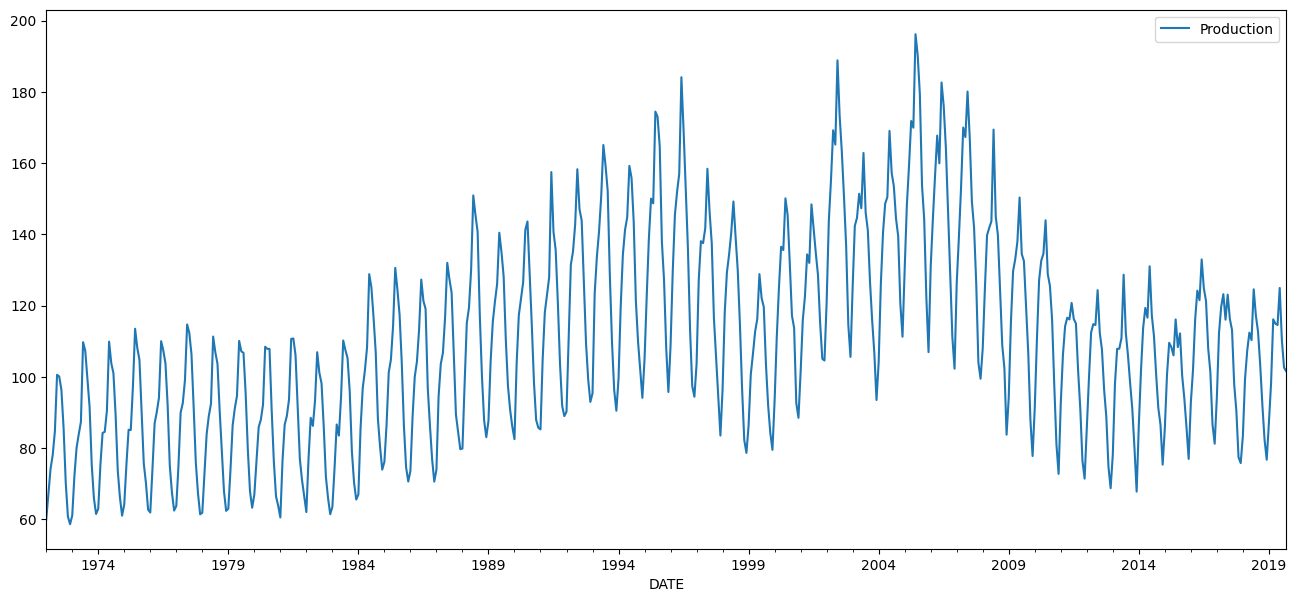

In [92]:
csv = pd.read_csv('../data/Frozen_Dessert_Production.csv', parse_dates=True, index_col='DATE')
data = pd.DataFrame(csv)
data.columns = ["Production"]
data
data.plot(figsize=(16,7))

In [93]:
splitindex = len(data)-24
train = data.iloc[:splitindex]
test = data.iloc[splitindex:]


In [94]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaledtraining = scaler.fit_transform(train)
scaledtesting = scaler.transform(test)

In [95]:
length = 20
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
traingenerator = TimeseriesGenerator(scaledtraining, scaledtraining,length=length, batch_size=1)
testgenerator = TimeseriesGenerator(scaledtesting, scaledtesting, length=length, batch_size=1)



In [96]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
numfeatures = 1 #number of features in dataset, we only have one value
model = Sequential([
    LSTM(units=150,input_shape=(length,numfeatures)),
    Dense(1)
])
earlycallback = EarlyStopping(monitor='val_loss', patience=4)
model.compile(optimizer='adam',loss='mse')
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 150)               91200     
                                                                 
 dense_4 (Dense)             (None, 1)                 151       
                                                                 
Total params: 91351 (356.84 KB)
Trainable params: 91351 (356.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [97]:
model.fit_generator(traingenerator, epochs=100,
                    validation_data=testgenerator,
                    callbacks=[earlycallback])

Epoch 1/100


C:\Users\alife\AppData\Local\Temp\ipykernel_19068\1648774985.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(traingenerator, epochs=100,


529/529 [==============================] - 18s 23ms/step - loss: 0.0174 - val_loss: 0.0043
Epoch 2/100
529/529 [==============================] - 8s 16ms/step - loss: 0.0056 - val_loss: 0.0024
Epoch 3/100
529/529 [==============================] - 9s 16ms/step - loss: 0.0045 - val_loss: 0.0022
Epoch 4/100
529/529 [==============================] - 9s 16ms/step - loss: 0.0038 - val_loss: 0.0058
Epoch 5/100
529/529 [==============================] - 9s 16ms/step - loss: 0.0035 - val_loss: 0.0023
Epoch 6/100
529/529 [==============================] - 9s 17ms/step - loss: 0.0034 - val_loss: 0.0050
Epoch 7/100
529/529 [==============================] - 9s 16ms/step - loss: 0.0034 - val_loss: 0.0040


<Axes: >

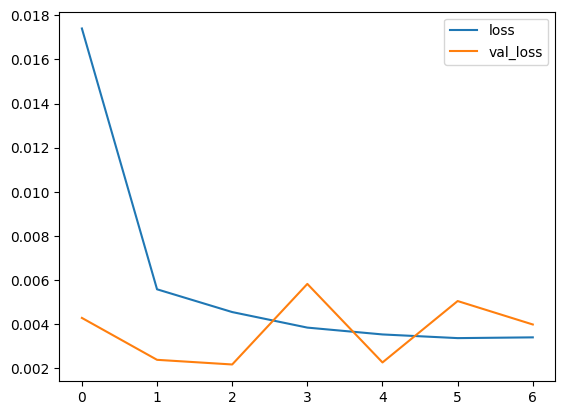

In [98]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [99]:

predictions = []
lastbatch = scaledtraining[-length:] #last batch in set
batch = lastbatch.reshape((1,length,1)) #rehsaping it to normal dimensions
for i in range(len(test)):
    pred = model.predict(batch)[0]
    predictions.append(pred)
    batch = np.append(batch[:,1:,:],[[pred]], axis=1) #take everything besdies the first valu
    #and then add our prediction at the end, axis=1, #batch size dont change, second and end for length, and then the n features dont chnage
    
realpredit = scaler.inverse_transform(predictions)


1/1 [==============================] - 0s 44ms/step


In [102]:
test['Predictions'] = realpredit

C:\Users\alife\AppData\Local\Temp\ipykernel_19068\418471243.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = realpredit


<Axes: xlabel='DATE'>

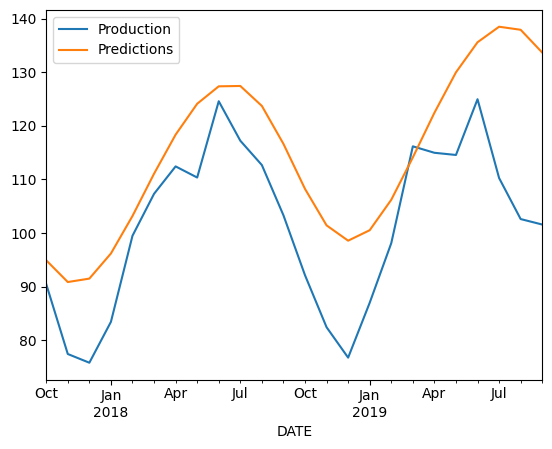

In [105]:
test.plot()

In [106]:
from sklearn.metrics import mean_squared_error
print("error: ", np.sqrt(mean_squared_error(test['Production'], test["Predictions"])))
#THIS MSE IS SHIT, CHNANGE IT

error:  15.940039100439026
